In [ ]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import re

def get_html(url, cookies):
    ua = UserAgent()
    headers = {'User-Agent': ua.random,
               'Cookie': cookies,
               'Host':'www.dianping.com'}
    req = Request(url, headers=headers)
    html = urlopen(req).read().decode('utf-8')
    return html

# 抓取首页

In [141]:
url = 'http://www.dianping.com/ch0'

In [142]:
html = get_html(url,cookies)

In [143]:
soup = BeautifulSoup(html)
soup

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<title>大众点评网_美食，生活，优惠券，团购</title>
<link href="//www.dpfile.com/s/res/favicon.5ff777c11d7833e57e01c9d192b7e427.ico" rel="Shortcut Icon" type="image/x-icon"/>
<meta content="中国城市消费指南 餐馆美食 购物 休闲娱乐 生活服务 活动优惠 打折信息 大众点评网 第一家也是领先的web2.0式的本地搜索门户" name="Keywords"/>
<meta content="中国城市消费指南 餐馆美食、购物、休闲娱乐、生活服务、活动优惠打折信息。大众点评网是中国第一家也是领先的web2.0式的本地搜索门户。商户的信息和评价全部由会员共同管理和维护。" name="Description"/>
<meta content="format=html5; url=http://m.dianping.com" http-equiv="mobile-agent"/>
<meta content="format=xhtml; url=http://wap.dianping.com" http-equiv="mobile-agent"/>
<!--1. 首先引入页头模块css，保证页头模块css在前，首先渲染 -->
<link href="//www.dpfile.com/app/pc-common/index.min.a7731187d67a7291f95e8fd4f4e36a9e.css" rel="stylesheet" type="text/css"/>
<!--2. 引入页头模块 js -->
<script src="//www.dpfile.com/app/pc-common/index.min.721448833c67392119cea625f8ff4da2.js" type="text/javascript"></script>
<link href="//www.dpfile.com/app/dpindex-new-static/static/citylist.min.

In [27]:
samp = soup.find_all('a', {'href': re.compile('http://www.dianping.com/suzhou/(.*?)')})
samp

[<a class="index-title" data-category="index.food" data-click-name="ch10" data-click-title="first" href="http://www.dianping.com/suzhou/ch10" target="_blank">美食</a>,
 <a class="index-item" data-category="index.food" data-click-name="g110" data-click-title="second" href="http://www.dianping.com/suzhou/ch10/g110" target="_blank"><span>火锅</span></a>,
 <a class="index-item" data-category="index.food" data-click-name="g117" data-click-title="second" href="http://www.dianping.com/suzhou/ch10/g117" target="_blank"><span>面包甜点</span></a>,
 <a class="more-cate" data-category="index.food" data-click-name="more" href="http://www.dianping.com/suzhou/ch10" target="_blank">更多<i class="icon-right icon-right-hover"></i></a>,
 <a class="second-item" data-category="index.food" data-click-name="g110" href="http://www.dianping.com/suzhou/ch10/g110" target="_blank">火锅</a>,
 <a class="second-item" data-category="index.food" data-click-name="g101" href="http://www.dianping.com/suzhou/ch10/g101" target="_blank

# 抓取火锅

In [1]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import re
from fake_useragent import UserAgent
import pandas as pd
import numpy as np

ua = UserAgent(verify_ssl=False)

def get_html(url, cookies):
    ua = UserAgent()
    headers = {'User-Agent': ua.random,
               'Cookie': cookies,
               'Host':'www.dianping.com'}
    req = Request(url, headers=headers)
    html = urlopen(req).read().decode('utf-8')
    return html

def check_error(lab):
    try:
        pic = lab.get_text().replace('\n','').strip(") ").split('(')[1]
    except (ZeroDivisionError, Exception) as e:
        pic = 0
    return pic

def get_details(html, cookies):
    soup = BeautifulSoup(html)
    df_st = pd.DataFrame({"店铺名称":[], "价格":[], "评价星级":[], "口味":[], "环境":[], "服务":[], "评论数":[],
                       "评论标签":[], '图片评论数':[], '好评数':[], '中评数':[], 
                       '差评数':[],'店铺地址':[]})
    # get store names, store links
    stores = soup.find_all('a', {'data-click-name':"shop_title_click"})
    for each in stores:
        # initial
        good_list = []
        bad_list = []
        # 店铺名称
        name = each['title']
        cur_url = each['href'] + '/review_all'
        review_html = get_html(cur_url, cookies)
        review_soup = BeautifulSoup(review_html)
        #评论
        lab = review_soup.find_all('label')[1:]
        pic = check_error(lab[0])
        good = check_error(lab[1])
        comm = check_error(lab[2])
        bad = check_error(lab[3])
        # 几颗星
        stars = review_soup.find_all('span', {'class':re.compile("star(.*?)")})[0]['class'][1]
        stars = int(stars[-2:])/10
        # 评论数
        num_reviews = int(review_soup.find_all('span', {'class': "reviews"})[0].get_text()[:-3])
        # 价格
        prices = float(review_soup.find_all('span', {'class': "price"})[0].get_text().split("：")[1][:-1])
        # 口味
        taste = float(review_soup.find_all('span', {'class': "item"})[:3][0].get_text().split("：")[1])
        # 环境
        enviro = float(review_soup.find_all('span', {'class': "item"})[:3][1].get_text().split("：")[1])
        # 服务
        serv = float(review_soup.find_all('span', {'class': "item"})[:3][2].get_text().split("：")[1])
        # address
        addre = review_soup.find_all('div', {'class': "address-info"})[0].get_text().replace('\n','').replace('\xa0', '').strip()
        # 正面评论
        good_tag_list = review_soup.find_all('span', {'class': 'good tag'})
        for each in good_tag_list:
            sub = each.get_text().split()
            sub = "".join(sub)
            good_list.append(sub)
        good_tag = ",".join(good_list)
        #负面评论
        bad_tag_list = review_soup.find_all('span', {'class': 'bad tag'})
        for each in bad_tag_list:
            sub = each.get_text().split()
            sub = "".join(sub)
            bad_list.append(sub)
        bad_tag = ",".join(bad_list)
        total_tag = good_tag +"," + bad_tag
        sub_df = pd.DataFrame({"店铺名称":[name],"价格":[prices], "评价星级":[stars],  
                              "口味":[taste], "环境":[enviro], "服务":[serv], "评论数":[num_reviews],
                               "评论标签":[total_tag], '图片评论数':[int(pic)], '好评数':[int(good)], '中评数':[int(comm)], 
                       '差评数':[int(bad)], '店铺地址':[addre]})
        df_st = pd.concat([df_st, sub_df], ignore_index=True)
    return df_st
    # get store names, store links

In [2]:
def change_url(url, indx):
    return url + 'p'+ str(indx) + '?cpt=H75YfFvua5AsuKgJ%2Cl1fVt1tqFGWaxQm8%2Cl2Iuu1vMpEPz8Fj1%2CkauCuZ57blBDYvz6%2CG7MHGfOKJY0MEL8a%2Ck6JeW8C9WtuMMJk5'


def over_all(start, pages, cookies):
    samp_url = "http://www.dianping.com/suzhou/ch10/g110"
    df = pd.DataFrame({"店铺名称":[], "价格":[], "评价星级":[], "口味":[], "环境":[], "服务":[], "评论数":[],
                       "评论标签":[], '图片评论数':[], '好评数':[], '中评数':[], 
                       '差评数':[],'店铺地址':[]})
    
    for indx in range(start, pages):
        url = change_url(samp_url, indx)
        html = get_html(url, cookies)
        disapp = re.findall(r'页面不存在', html)
        while len(disapp) != 0:
            print('发现验证码，停止运行')
            print('请点击下列网页验证: ' + str(url))
            print("目前爬虫爬到第"+ str(indx)+ "页")
            usr = input()
            html = get_html(url, cookies)
            disapp = re.findall(r'页面不存在', html)
        print("目前爬虫正在爬第"+ str(indx)+ "页")
        subdf = get_details(html, cookies)
        df = pd.concat([df, subdf], ignore_index=True)
        df.to_csv('Barry.csv')

In [5]:
cookies = '# 此处添加自己的cookies'

In [13]:
over_all(10, 51, cookies)

目前爬虫正在爬第10页
目前爬虫正在爬第11页
目前爬虫正在爬第12页
目前爬虫正在爬第13页
目前爬虫正在爬第14页
目前爬虫正在爬第15页
目前爬虫正在爬第16页
目前爬虫正在爬第17页
目前爬虫正在爬第18页
目前爬虫正在爬第19页
目前爬虫正在爬第20页
目前爬虫正在爬第21页
目前爬虫正在爬第22页
目前爬虫正在爬第23页
目前爬虫正在爬第24页
目前爬虫正在爬第25页
目前爬虫正在爬第26页
目前爬虫正在爬第27页
目前爬虫正在爬第28页
目前爬虫正在爬第29页
目前爬虫正在爬第30页
目前爬虫正在爬第31页
目前爬虫正在爬第32页
目前爬虫正在爬第33页
目前爬虫正在爬第34页
目前爬虫正在爬第35页
目前爬虫正在爬第36页
目前爬虫正在爬第37页
目前爬虫正在爬第38页
目前爬虫正在爬第39页
目前爬虫正在爬第40页
目前爬虫正在爬第41页
目前爬虫正在爬第42页
目前爬虫正在爬第43页
目前爬虫正在爬第44页
目前爬虫正在爬第45页
目前爬虫正在爬第46页
目前爬虫正在爬第47页
目前爬虫正在爬第48页
目前爬虫正在爬第49页
目前爬虫正在爬第50页


## 数据处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('大众点评火锅数据.csv')
df.head()

,店铺名称,价格,评价星级,口味,环境,服务,评论数,评论标签,图片评论数,好评数,中评数,差评数,店铺地址
0,渝味晓宇火锅(苏州中心店),122.0,4.0,7.8,8.1,7.8,1287.0,"菜品健康(91),不用排队(53),上菜快(27),回头客(26),朋友聚餐(18),闺蜜聚...",668.0,885.0,195.0,207.0,地址:星街苏心区L5层
1,古乐牛香牛肉 牛杂火锅(观前街店),68.0,5.0,9.1,8.9,9.0,4836.0,"回头客(245),上菜快(116),不用排队(99),发发呆(24),到店自提(173),朋...",3301.0,4402.0,266.0,168.0,地址:邵磨针巷80-82
2,谭鸭血老火锅(绿宝店),111.0,4.5,8.8,9.0,8.8,1450.0,"菜品健康(143),回头客(37),停车方便(31),上菜快(31),不用排队(25),朋友...",1138.0,1272.0,132.0,46.0,地址:江绿宝休闲购物场绿宝二期步行5幢101
3,海汕牛香(iD PARK 歌林公园店),99.0,4.0,8.4,8.4,8.1,67.0,"服务热情(23),环境很好(23),味道赞(13),牛肉赞(12),性价比高(12),菜品健...",60.0,60.0,5.0,2.0,地址:鹅荡1-1iD PARK 歌公H522
4,旺府火锅(斜塘老街店),115.0,4.5,8.7,8.9,8.7,2853.0,"菜品健康(262),停车方便(84),回头客(84),不用排队(43),有表演(10),夜景...",1199.0,2493.0,240.0,120.0,地址:灯火巷斜塘老53幢402室


In [2]:
df = df.sort_values(by=['评价星级'], ascending=False)
df = df.reset_index(drop=True)
df.head()

,店铺名称,价格,评价星级,口味,环境,服务,评论数,评论标签,图片评论数,好评数,中评数,差评数,店铺地址
0,九鼎轩脆毛肚火锅(昆山吾悦店),111.0,5.0,9.1,9.1,9.1,2083.0,"上菜快(293),回头客(270),海鲜棒(13),停车方便(4),不用排队(3),到店自提...",680.0,1952.0,72.0,59.0,地址:长江99新吾悦55004 (交24.208.213到吾悦广站下)
1,巴四老城区炭火蛙锅(现代传媒广场店),93.0,5.0,9.1,9.2,9.2,1336.0,"上菜快(56),回头客(48),停车方便(33),不用排队(23),朋友聚餐(29),到店自...",935.0,1276.0,51.0,9.0,地址:大265号现代传媒3楼
2,新东方羊肉店(穹窿路店),81.0,5.0,9.0,8.8,8.9,1091.0,"停车方便(179),上菜快(147),回头客(26),不用排队(8),到店自提(66),朋友...",861.0,954.0,83.0,45.0,地址:穹窿路80
3,云南抚仙渔王·养生蒸汽石锅鱼(兆丰店),77.0,5.0,9.1,9.1,9.1,195.0,"服务热情(99),肉类好(50),味道赞(46),菜品健康(30),海鲜棒(18),上菜快(...",105.0,175.0,11.0,8.0,地址:丰路花桥兆丰99光生活场4楼
4,金科土火锅(王府店),152.0,5.0,9.1,9.2,9.1,2443.0,"菜品健康(358),上菜快(128),回头客(90),停车方便(46),不用排队(9),朋友...",1017.0,2260.0,120.0,62.0,地址:滨1969金科大酒店3F


In [3]:
df.describe()

,价格,评价星级,口味,环境,服务,评论数,图片评论数,好评数,中评数,差评数
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.00000,725.000000,725.000000,725.000000
mean,99.979310,4.448276,8.631172,8.615448,8.615724,1212.161379,556.54069,1051.193103,102.943448,57.419310
std,48.315416,0.433109,0.468062,0.469787,0.477651,1932.222931,764.40203,1580.808147,249.813977,170.892541
min,0.000000,3.000000,7.000000,7.000000,7.000000,7.000000,1.00000,7.000000,0.000000,0.000000
25%,73.000000,4.000000,8.300000,8.300000,8.300000,250.000000,140.00000,222.000000,18.000000,8.000000
50%,97.000000,4.500000,8.700000,8.700000,8.700000,573.000000,311.00000,505.000000,45.000000,24.000000
75%,119.000000,5.000000,9.000000,9.000000,9.000000,1426.000000,649.00000,1254.000000,109.000000,62.000000
max,714.000000,5.000000,9.300000,9.300000,9.400000,24994.000000,6645.00000,17730.000000,4124.000000,3140.000000


## Boxplot 分析

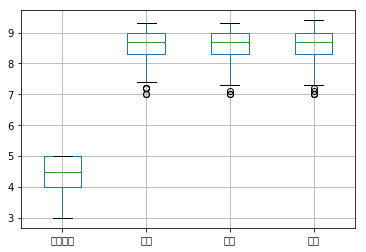

In [4]:
df.boxplot(column=['评价星级', '口味', '环境', '服务'])

In [5]:
# Quantiles
Q1 = df[['评价星级', '口味', '环境', '服务']].quantile(0.25)
Q3 = df[['评价星级', '口味', '环境', '服务']].quantile(0.75)
IQR = Q3 - Q1
IQR

评价星级    1.0
口味      0.7
环境      0.7
服务      0.7
dtype: float64

In [6]:
out_df = df[(df['口味'] < Q1[1] - 1.5*IQR[1]) | (df['环境'] <  Q1[2] - 1.5*IQR[2]) | (df['服务'] <  Q1[3] - 1.5*IQR[3])]
out_df ###远低于平均标准

,店铺名称,价格,评价星级,口味,环境,服务,评论数,评论标签,图片评论数,好评数,中评数,差评数,店铺地址
594,贵州黄牛肉馆,70.0,4.0,8.4,7.1,7.5,167.0,"味道赞(59),牛肉赞(39),菜品精致(13),停车方便(11),分量足(6),主食赞(5...",100.0,142.0,22.0,3.0,地址:挺河三电子有限司斜对面
689,重庆刘一手毛肚火锅(望亭店),0.0,3.5,7.2,7.3,7.0,15.0,"环境很好(4),服务热情(3),",6.0,9.0,4.0,2.0,地址:鹤溪1
699,谭鸭血老火锅(万达店),114.0,3.5,7.0,7.0,7.0,134.0,"服务热情(37),味道赞(22),牛肉赞(12),菜品健康(11),上菜快(8),回头客(4...",66.0,89.0,22.0,23.0,地址:太仓上海万达广场楼 (同庆旁)
708,小馋客火锅,0.0,3.5,7.0,7.0,7.0,16.0,"性价比高(7),味道赞(6),服务热情(5),菜品健康(3),价格实惠(3),到店自提(1)...",10.0,12.0,2.0,2.0,地址:门路587号
713,富士山下锅物料理,82.0,3.5,7.2,7.3,7.2,226.0,"环境很好(43),味道赞(26),回头客(7),交通便利(6),上菜快(4),牛肉赞(3),...",143.0,148.0,52.0,26.0,地址:塔弄方塔街32，漫猫下侧
724,电台巷火锅(新区旗舰店),112.0,3.0,7.2,7.5,7.1,392.0,"牛肉赞(65),不用排队(21),回头客(13),停车方便(4),店内消毒(6),朋友聚餐(...",294.0,235.0,110.0,47.0,地址:市高新区塔路201号01幢汉堡王旁 (易活购物)


In [7]:
# 筛选星级
df[df['评价星级'] == 4.0]

,店铺名称,价格,评价星级,口味,环境,服务,评论数,评论标签,图片评论数,好评数,中评数,差评数,店铺地址
487,钢管厂五区小郡肝火锅串串香,66.0,4.0,8.3,8.3,8.3,886.0,"味道赞(212),牛肉赞(82),菜品健康(74),回头客(60),上菜快(40),不用排队...",258.0,772.0,71.0,43.0,地址:春晖路755 (宝宸足楼下)
488,上禾塘·蒜锅鱼头(盛泽凤凰荟店),74.0,4.0,8.1,8.1,8.0,129.0,"味道赞(34),服务热情(28),性价比高(24),菜品精致(18),肉类好(16),价格实...",49.0,112.0,14.0,3.0,地址:盛泽镇路588盛泽凤荟购物中心
489,浔城壹号(吴江店),240.0,4.0,7.8,7.9,7.8,241.0,"菜品不错(46),上菜快(12),海鲜棒(10),高大上(6),停车方便(5),牛肉赞(5)...",94.0,206.0,20.0,15.0,地址:康路738号
490,呷哺呷哺(九方城店),67.0,4.0,8.2,8.2,8.2,576.0,"菜品健康(55),回头客(30),上菜快(20),高大上(5),不用排队(3),海鲜棒(3)...",216.0,457.0,69.0,50.0,地址:萧路666号地下B-003
491,就这么拌(新区永旺店),33.0,4.0,7.9,8.2,8.1,491.0,"味道赞(160),回头客(20),上菜快(5),肉类好(5),不用排队(4),菜品卖相不佳(...",244.0,390.0,56.0,45.0,地址:际路旺梦一165号
492,大斌家串串火锅(相城店),85.0,4.0,8.7,8.8,8.9,214.0,"味道赞(92),菜品健康(31),牛肉赞(18),停车方便(13),回头客(8),交通便利(...",151.0,193.0,13.0,8.0,地址:元和街元路万客隆商城6幢365 (欧商)
493,欢乐工场国际自助烤肉火锅,67.0,4.0,8.0,8.5,8.2,24994.0,"回头客(845),不用排队(112),店内消毒(4),朋友聚餐(247),深夜食堂(76),...",2174.0,17730.0,4124.0,3140.0,地址:方塔步行东5号3 (原欢乐牧，八佰伴对面)
494,鱼小腰石锅鱼烤鱼(观前店),60.0,4.0,8.1,8.1,8.4,116.0,"味道赞(39),服务热情(33),性价比高(27),菜品精致(20),价格实惠(16),肉类...",75.0,101.0,10.0,5.0,地址:碧川福美食城要德火锅2（豪客来牛排斜对面）
495,一品焖锅(昆山九方店),87.0,4.0,8.1,8.4,8.0,1925.0,"回头客(51),不用排队(10),海鲜棒(4),停车方便(3),到店自提(2),朋友聚餐(1...",435.0,1388.0,291.0,246.0,地址:昆北方购物心55-008室
496,重庆高老九火锅(昆山万达店),107.0,4.0,8.2,8.2,8.2,1495.0,"菜品健康(146),上菜快(88),回头客(74),不用排队(8),停车方便(5),到店自提...",509.0,1304.0,114.0,77.0,地址:青阳北218万达广一三3001-3002


In [8]:
# 好评率
df['好评率'] = df['好评数']/df['评论数']
df['差评率'] = df['差评数']/df['评论数']

df[['评价星级', '好评率', '差评率']]

,评价星级,好评率,差评率
0,5.0,0.937110,0.028325
1,5.0,0.955090,0.006737
2,5.0,0.874427,0.041247
3,5.0,0.897436,0.041026
4,5.0,0.925092,0.025379
5,5.0,0.937824,0.031088
6,5.0,0.920573,0.021032
7,5.0,0.894072,0.036735
8,5.0,0.919014,0.019366
9,5.0,0.886193,0.024265


In [9]:
## 删除某列
df = df.drop(columns='好评率')
df.columns

Index(['店铺名称', '价格', '评价星级', '口味', '环境', '服务', '评论数', '评论标签', '图片评论数', '好评数',
       '中评数', '差评数', '店铺地址', '差评率'],
      dtype='object')

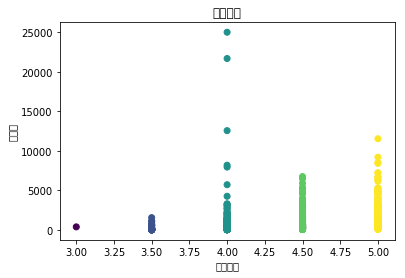

In [10]:
df1 = df[['评价星级','评论数']]
plt.scatter(x=df['评价星级'],y=df['评论数'], c = df['评价星级'])

plt.xlabel('评价星级')
plt.ylabel('评论数')
plt.title('题目是啥')
plt.show()


## 标签

In [11]:
tags = df['评论标签']
adic = {}
set_tags = set()
for code in tags:
    code_list = code.split(',')
    for each in code_list:
        if each == "":
            continue
        # 内部分离
        tags = each.replace('(', " ").replace(")","").split()
        # 得到名字，数量
        if tags[0] not in set_tags:
            set_tags.add(tags[0])
        
        if tags[0] not in adic.keys():
            adic[tags[0]] = int(tags[1])
        else:
            adic[tags[0]] += int(tags[1])

In [12]:
food_list = []
taged_times = []
for key, value in adic.items():
    food_list.append(key)
    taged_times.append(value)
df_tags = pd.DataFrame({'菜品标签':food_list, '标记次数':taged_times})
df_tags.head()

,菜品标签,标记次数
0,上菜快,15662
1,回头客,40755
2,海鲜棒,3049
3,停车方便,5740
4,不用排队,11153


In [13]:
df_tags = df_tags.sort_values(by=['标记次数'], ascending=False)
df_tags = df_tags.reset_index(drop=True)
df_tags.head()

,菜品标签,标记次数
0,回头客,40755
1,菜品健康,40366
2,上菜快,15662
3,味道赞,12223
4,朋友聚餐,12119


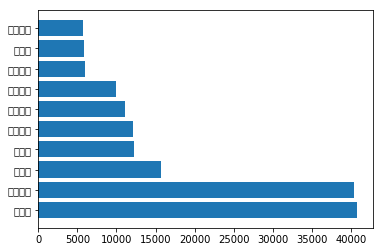

In [14]:
plt.barh(range(len(df_tags['标记次数'][:10])), df_tags['标记次数'][:10], tick_label = df_tags['菜品标签'][:10])
plt.show()

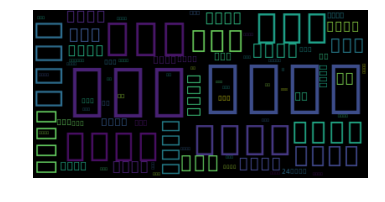

In [15]:
# wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=adic)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()